# passive low pass

------------------------------
Filter Performance Analysis
------------------------------
Passband Reference Gain: -0.44 dB
Passband Ripple:         2.50 dB
Cutoff Frequency (-3dB): 2838.50 Hz
Roll-off Rate (Slope):   -19.07 dB/decade
Stopband Attenuation:    -20.61 dB (at 28.4 kHz)
Phase at Cutoff:         -43.03 degrees
------------------------------


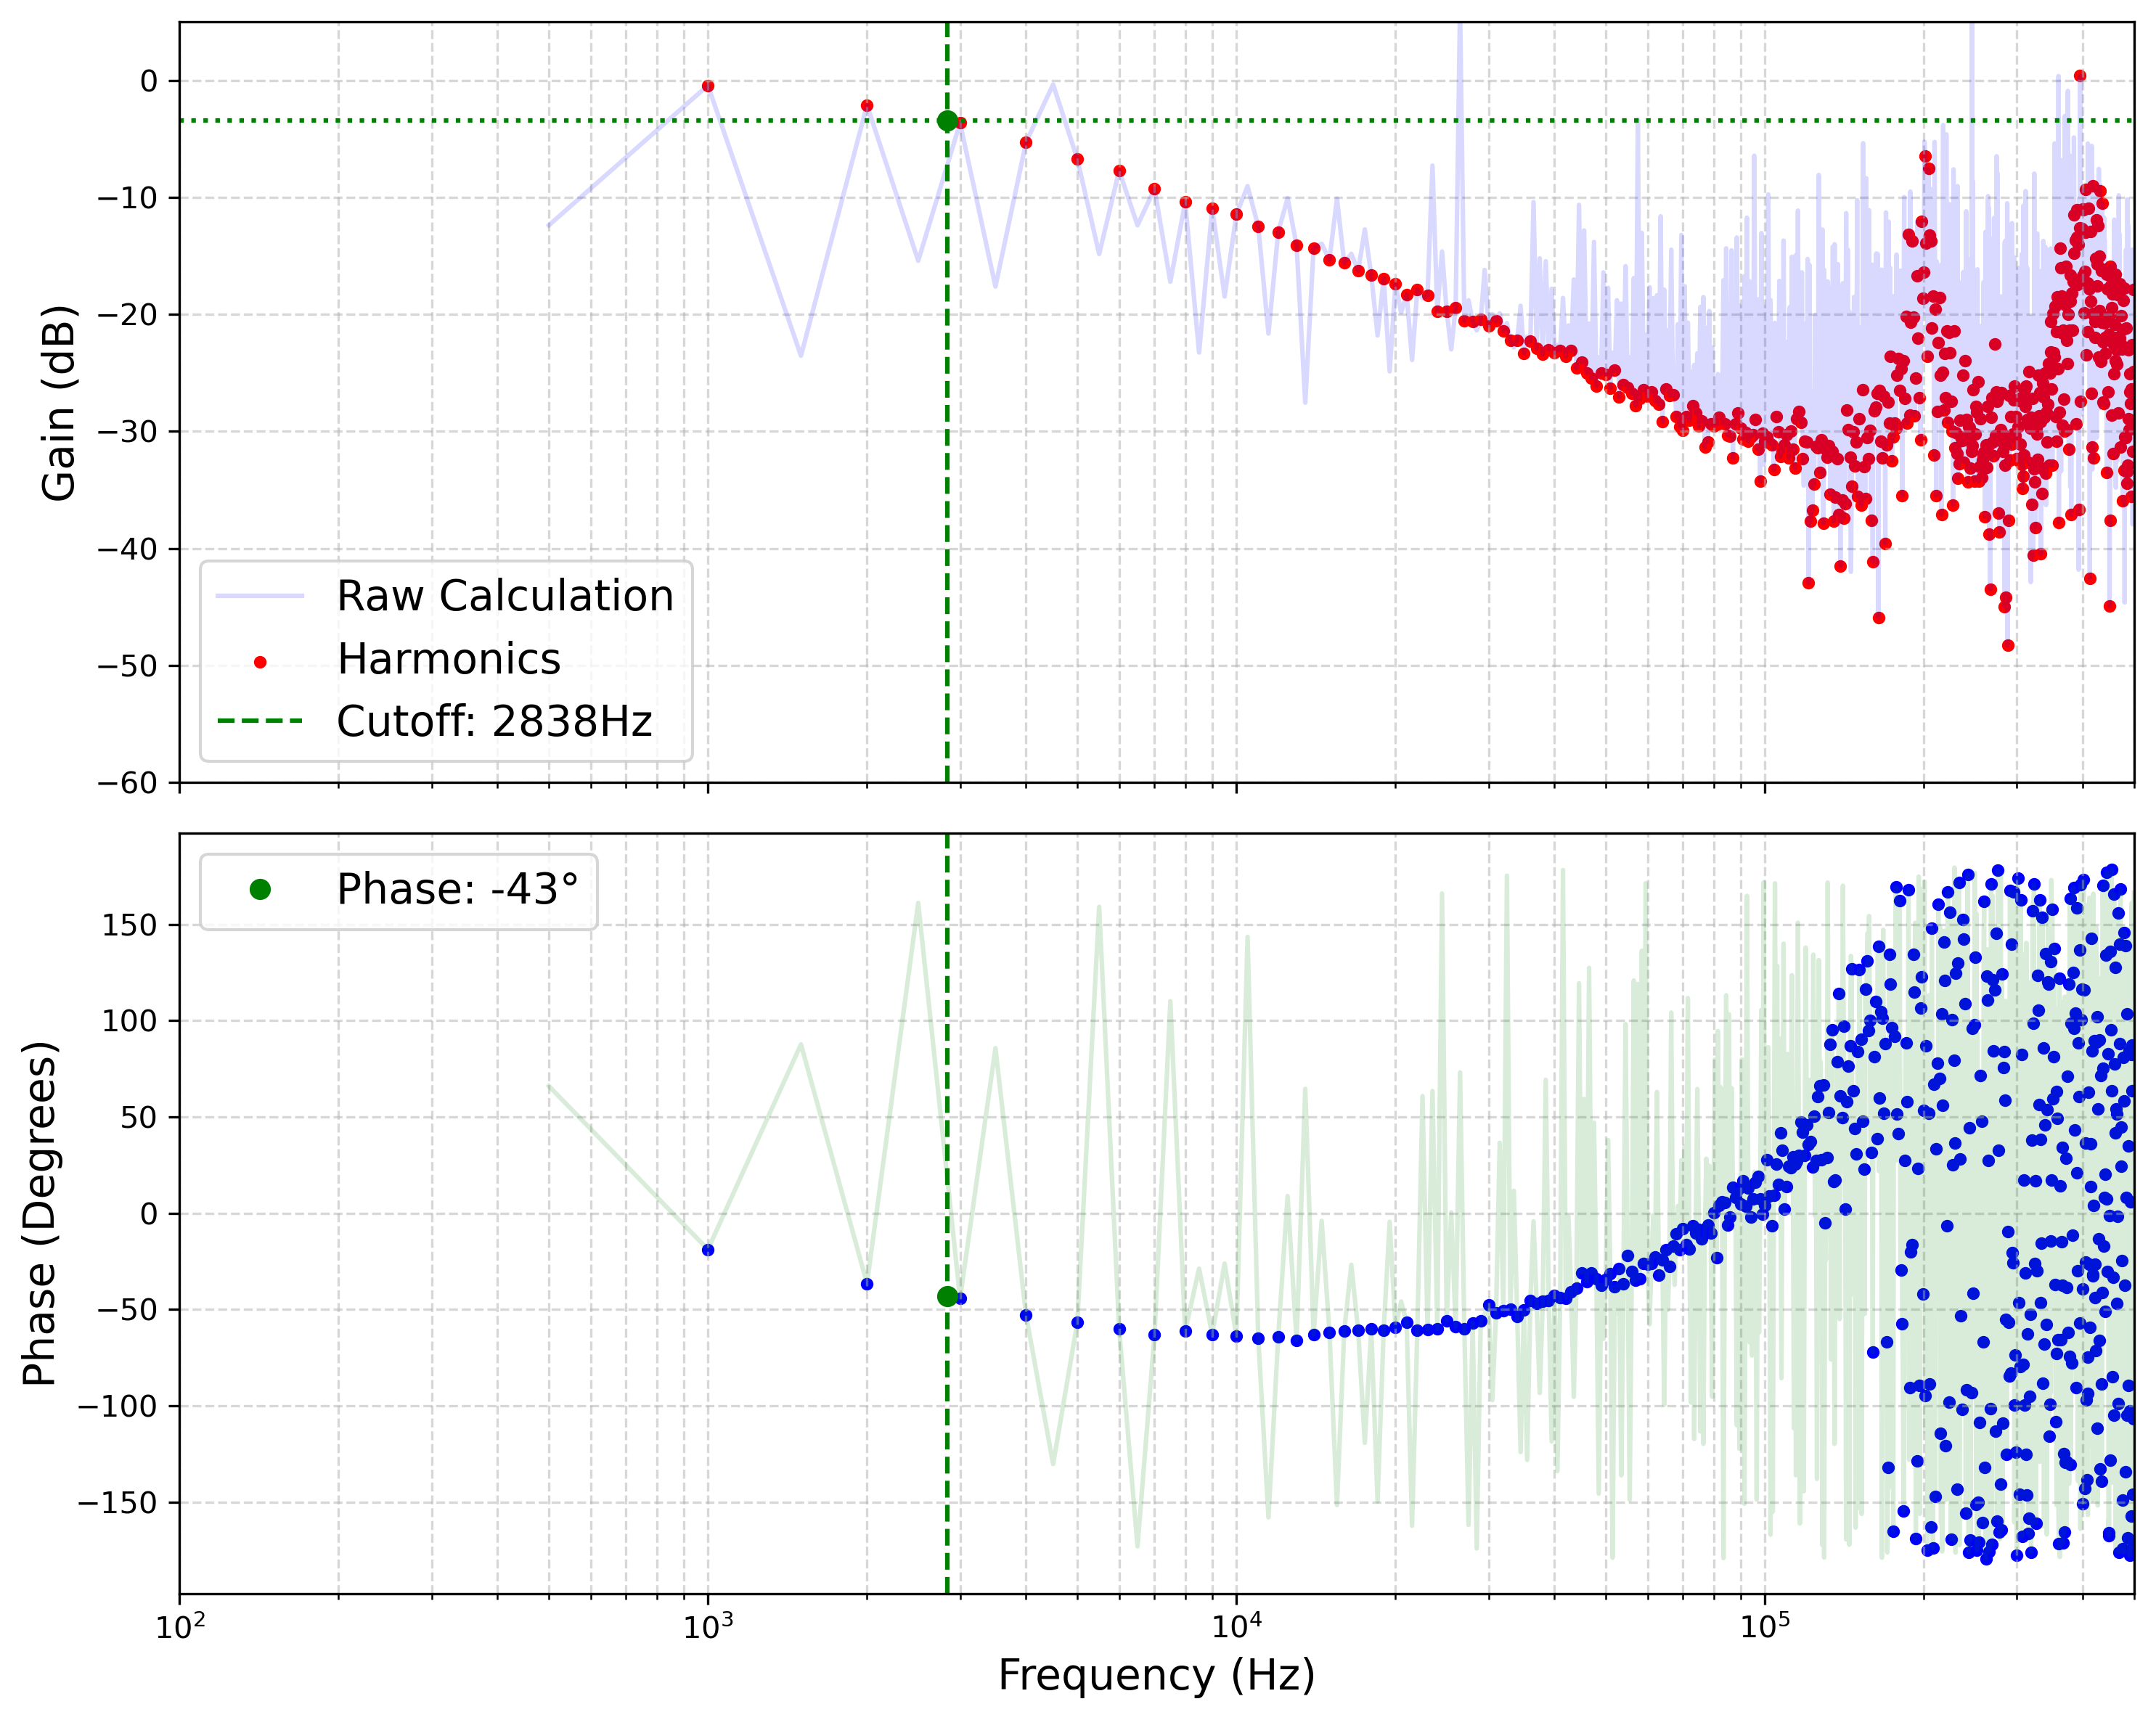

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# 1. Load the data
# Ensure 'input(output).csv' and 'passive_lowpass(output).csv' are in your directory
df_in = pd.read_csv('input(output).csv')
df_out = pd.read_csv('passive_lowpass(output).csv')

# Use the shorter of the two if they differ slightly in length
n = min(len(df_in), len(df_out))
t = df_in['second'].values[:n]
v_in = df_in['Volt'].values[:n]
v_out = df_out['Volt'].values[:n]

# Calculate sampling parameters
dt = t[1] - t[0]
fs = 1.0 / dt

# 2. Perform FFT
fft_in = np.fft.fft(v_in)
fft_out = np.fft.fft(v_out)
freqs = np.fft.fftfreq(n, dt)

# Focus only on positive frequencies
mask = (freqs > 0) & (freqs < fs/2)
f = freqs[mask]
# Calculate Transfer Function H(f)
# Add small epsilon to input to avoid division by zero
H = fft_out[mask] / (fft_in[mask] + 1e-12)

# 3. Calculate Magnitude and Phase
magnitude_db = 20 * np.log10(np.abs(H) + 1e-12)
phase_deg = np.degrees(np.angle(H))

# --- NEW: Parameter Analysis Logic ---

# We extract data only at the harmonics (1kHz, 2kHz...) to perform calculations
# This avoids the "noise" between harmonics
harmonic_indices = np.where((f % 1000 < 50) | (f % 1000 > 950))[0]
f_harm = f[harmonic_indices]
mag_harm = magnitude_db[harmonic_indices]
phase_harm = phase_deg[harmonic_indices]

# A. Passband Gain & Ripple
# Assumes passband starts at DC. Reference is the 1kHz gain.
ref_gain = mag_harm[0] 
# Ripple is the variation before the cutoff point (where gain drops by >3dB)
passband_mask = mag_harm > (ref_gain - 3.0)
if np.any(passband_mask):
    ripple = mag_harm[passband_mask].max() - mag_harm[passband_mask].min()
else:
    ripple = 0.0

# B. Cutoff Frequency (-3dB point)
# Find where gain drops 3dB below the 1kHz reference
cutoff_val = ref_gain - 3.0
cutoff_freq = np.nan

# Interpolate between harmonics to find exact frequency crossing -3dB
for i in range(len(mag_harm) - 1):
    if mag_harm[i] >= cutoff_val and mag_harm[i+1] < cutoff_val:
        # Linear interpolation in Log-Frequency domain
        x1, x2 = np.log10(f_harm[i]), np.log10(f_harm[i+1])
        y1, y2 = mag_harm[i], mag_harm[i+1]
        m = (y2 - y1) / (x2 - x1)
        x_cutoff = (cutoff_val - y1) / m + x1
        cutoff_freq = 10**x_cutoff
        break

# C. Roll-off Rate (Slope)
# Calculate slope between 2x Cutoff and 10x Cutoff
slope = np.nan
if not np.isnan(cutoff_freq):
    slope_mask = (f_harm >= cutoff_freq * 2) & (f_harm <= cutoff_freq * 10)
    if np.sum(slope_mask) > 1:
        # Perform linear regression on log-log data
        slope_f = np.log10(f_harm[slope_mask])
        slope_mag = mag_harm[slope_mask]
        slope_val, intercept, _, _, _ = linregress(slope_f, slope_mag)
        slope = slope_val # Result is in dB/decade

# D. Stopband Attenuation
# Measure attenuation at 10x the Cutoff Frequency
stop_freq = cutoff_freq * 10 if not np.isnan(cutoff_freq) else f_harm[-1]
idx_stop = np.argmin(np.abs(f_harm - stop_freq))
stopband_att = mag_harm[idx_stop]

# E. Phase at Cutoff
phase_at_cutoff = np.interp(cutoff_freq, f_harm, phase_harm) if not np.isnan(cutoff_freq) else np.nan

# Print Results
print("-" * 30)
print(f"Filter Performance Analysis")
print("-" * 30)
print(f"Passband Reference Gain: {ref_gain:.2f} dB")
print(f"Passband Ripple:         {ripple:.2f} dB")
print(f"Cutoff Frequency (-3dB): {cutoff_freq:.2f} Hz")
print(f"Roll-off Rate (Slope):   {slope:.2f} dB/decade")
print(f"Stopband Attenuation:    {stopband_att:.2f} dB (at {stop_freq/1000:.1f} kHz)")
print(f"Phase at Cutoff:         {phase_at_cutoff:.2f} degrees")
print("-" * 30)

# 4. Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, dpi=300, figsize=(10, 8), sharex=True)

# Plot Magnitude
ax1.semilogx(f, magnitude_db, color='blue', alpha=0.15, label='Raw Calculation')
ax1.scatter(f_harm, mag_harm, color='red', s=10, label='Harmonics')

# Annotate Cutoff
if not np.isnan(cutoff_freq):
    ax1.axvline(x=cutoff_freq, color='green', linestyle='--', label=f'Cutoff: {cutoff_freq:.0f}Hz')
    ax1.axhline(y=cutoff_val, color='green', linestyle=':')
    ax1.plot(cutoff_freq, cutoff_val, 'go')


ax1.set_ylabel('Gain (dB)', fontsize=14)
ax1.set_ylim(-60, 5)
ax1.grid(True, which="both", linestyle="--", alpha=0.5)
ax1.legend(fontsize =14)

# Plot Phase
ax2.semilogx(f, phase_deg, color='green', alpha=0.15)
ax2.scatter(f_harm, phase_harm, color='blue', s=10)
if not np.isnan(cutoff_freq):
    ax2.axvline(x=cutoff_freq, color='green', linestyle='--')
    ax2.plot(cutoff_freq, phase_at_cutoff, 'go', label=f'Phase: {phase_at_cutoff:.0f}°')

ax2.set_xlabel('Frequency (Hz)', fontsize =14)
ax2.set_ylabel('Phase (Degrees)', fontsize =14)
ax2.set_xlim(100, fs/2)
ax2.grid(True, which="both", linestyle="--", alpha=0.5)
ax2.legend(fontsize = 14)

plt.tight_layout()
plt.savefig('passive_lowpass.png')
plt.show()

# active low pass

------------------------------
Filter Performance Analysis
------------------------------
Passband Reference Gain: -0.50 dB
Passband Ripple:         1.58 dB
Cutoff Frequency (-3dB): 2902.04 Hz
Roll-off Rate (Slope):   -18.94 dB/decade
Stopband Attenuation:    -20.68 dB (at 29.0 kHz)
Phase at Cutoff:         -44.07 degrees
------------------------------


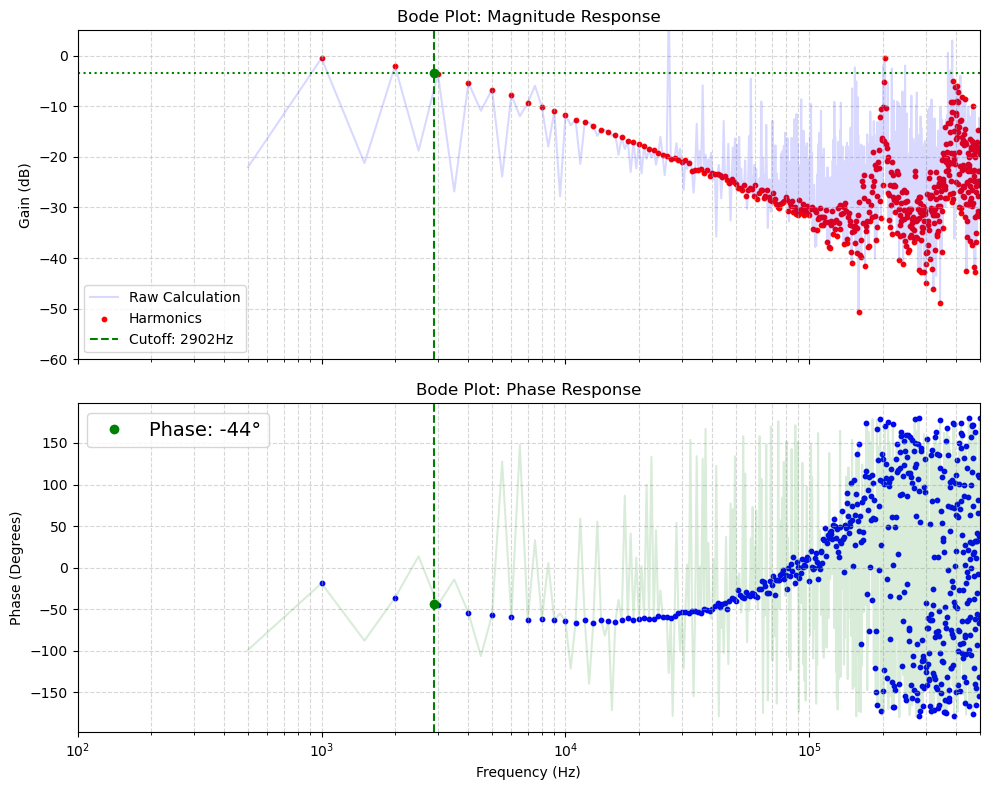

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# 1. Load the data
# Ensure 'input(output).csv' and 'passive_lowpass(output).csv' are in your directory
df_in = pd.read_csv('input(output).csv')
df_out = pd.read_csv('active_lowpass(output).csv')

# Use the shorter of the two if they differ slightly in length
n = min(len(df_in), len(df_out))
t = df_in['second'].values[:n]
v_in = df_in['Volt'].values[:n]
v_out = df_out['Volt'].values[:n]

# Calculate sampling parameters
dt = t[1] - t[0]
fs = 1.0 / dt

# 2. Perform FFT
fft_in = np.fft.fft(v_in)
fft_out = np.fft.fft(v_out)
freqs = np.fft.fftfreq(n, dt)

# Focus only on positive frequencies
mask = (freqs > 0) & (freqs < fs/2)
f = freqs[mask]
# Calculate Transfer Function H(f)
# Add small epsilon to input to avoid division by zero
H = fft_out[mask] / (fft_in[mask] + 1e-12)

# 3. Calculate Magnitude and Phase
magnitude_db = 20 * np.log10(np.abs(H) + 1e-12)
phase_deg = np.degrees(np.angle(H))

# --- NEW: Parameter Analysis Logic ---

# We extract data only at the harmonics (1kHz, 2kHz...) to perform calculations
# This avoids the "noise" between harmonics
harmonic_indices = np.where((f % 1000 < 50) | (f % 1000 > 950))[0]
f_harm = f[harmonic_indices]
mag_harm = magnitude_db[harmonic_indices]
phase_harm = phase_deg[harmonic_indices]

# A. Passband Gain & Ripple
# Assumes passband starts at DC. Reference is the 1kHz gain.
ref_gain = mag_harm[0] 
# Ripple is the variation before the cutoff point (where gain drops by >3dB)
passband_mask = mag_harm > (ref_gain - 3.0)
if np.any(passband_mask):
    ripple = mag_harm[passband_mask].max() - mag_harm[passband_mask].min()
else:
    ripple = 0.0

# B. Cutoff Frequency (-3dB point)
# Find where gain drops 3dB below the 1kHz reference
cutoff_val = ref_gain - 3.0
cutoff_freq = np.nan

# Interpolate between harmonics to find exact frequency crossing -3dB
for i in range(len(mag_harm) - 1):
    if mag_harm[i] >= cutoff_val and mag_harm[i+1] < cutoff_val:
        # Linear interpolation in Log-Frequency domain
        x1, x2 = np.log10(f_harm[i]), np.log10(f_harm[i+1])
        y1, y2 = mag_harm[i], mag_harm[i+1]
        m = (y2 - y1) / (x2 - x1)
        x_cutoff = (cutoff_val - y1) / m + x1
        cutoff_freq = 10**x_cutoff
        break

# C. Roll-off Rate (Slope)
# Calculate slope between 2x Cutoff and 10x Cutoff
slope = np.nan
if not np.isnan(cutoff_freq):
    slope_mask = (f_harm >= cutoff_freq * 2) & (f_harm <= cutoff_freq * 10)
    if np.sum(slope_mask) > 1:
        # Perform linear regression on log-log data
        slope_f = np.log10(f_harm[slope_mask])
        slope_mag = mag_harm[slope_mask]
        slope_val, intercept, _, _, _ = linregress(slope_f, slope_mag)
        slope = slope_val # Result is in dB/decade

# D. Stopband Attenuation
# Measure attenuation at 10x the Cutoff Frequency
stop_freq = cutoff_freq * 10 if not np.isnan(cutoff_freq) else f_harm[-1]
idx_stop = np.argmin(np.abs(f_harm - stop_freq))
stopband_att = mag_harm[idx_stop]

# E. Phase at Cutoff
phase_at_cutoff = np.interp(cutoff_freq, f_harm, phase_harm) if not np.isnan(cutoff_freq) else np.nan

# Print Results
print("-" * 30)
print(f"Filter Performance Analysis")
print("-" * 30)
print(f"Passband Reference Gain: {ref_gain:.2f} dB")
print(f"Passband Ripple:         {ripple:.2f} dB")
print(f"Cutoff Frequency (-3dB): {cutoff_freq:.2f} Hz")
print(f"Roll-off Rate (Slope):   {slope:.2f} dB/decade")
print(f"Stopband Attenuation:    {stopband_att:.2f} dB (at {stop_freq/1000:.1f} kHz)")
print(f"Phase at Cutoff:         {phase_at_cutoff:.2f} degrees")
print("-" * 30)

# 4. Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot Magnitude
ax1.semilogx(f, magnitude_db, color='blue', alpha=0.15, label='Raw Calculation')
ax1.scatter(f_harm, mag_harm, color='red', s=10, label='Harmonics')

# Annotate Cutoff
if not np.isnan(cutoff_freq):
    ax1.axvline(x=cutoff_freq, color='green', linestyle='--', label=f'Cutoff: {cutoff_freq:.0f}Hz')
    ax1.axhline(y=cutoff_val, color='green', linestyle=':')
    ax1.plot(cutoff_freq, cutoff_val, 'go')

ax1.set_title('Bode Plot: Magnitude Response')
ax1.set_ylabel('Gain (dB)')
ax1.set_ylim(-60, 5)
ax1.grid(True, which="both", linestyle="--", alpha=0.5)
ax1.legend()

# Plot Phase
ax2.semilogx(f, phase_deg, color='green', alpha=0.15)
ax2.scatter(f_harm, phase_harm, color='blue', s=10)
if not np.isnan(cutoff_freq):
    ax2.axvline(x=cutoff_freq, color='green', linestyle='--')
    ax2.plot(cutoff_freq, phase_at_cutoff, 'go', label=f'Phase: {phase_at_cutoff:.0f}°')

ax2.set_title('Bode Plot: Phase Response')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Phase (Degrees)')
ax2.set_xlim(100, fs/2)
ax2.grid(True, which="both", linestyle="--", alpha=0.5)
ax2.legend(fontsize = 14)

plt.tight_layout()
plt.show()

# 2nd Order low pass

------------------------------
Filter Performance Analysis
------------------------------
Passband Reference Gain: -0.98 dB
Passband Ripple:         2.88 dB
Cutoff Frequency (-3dB): 2073.82 Hz
Roll-off Rate (Slope):   -36.80 dB/decade
Stopband Attenuation:    -34.58 dB (at 20.7 kHz)
Phase at Cutoff:         -67.24 degrees
------------------------------


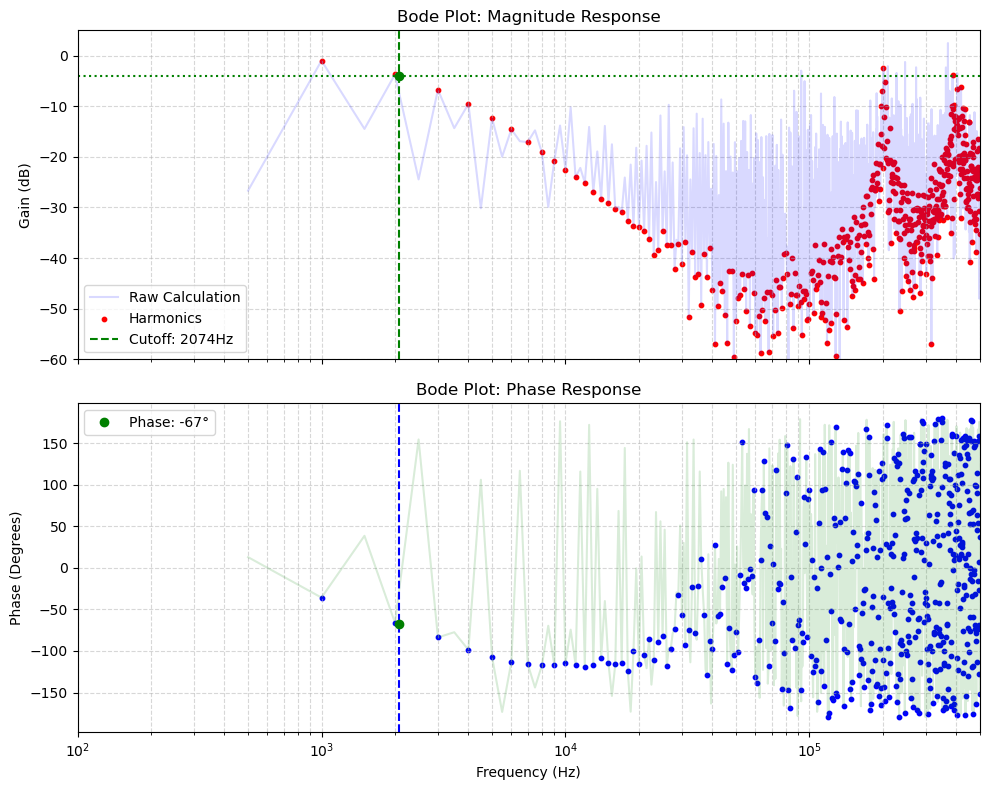

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# 1. Load the data
# Ensure 'input(output).csv' and 'passive_lowpass(output).csv' are in your directory
df_in = pd.read_csv('input(output).csv')
df_out = pd.read_csv('Second-Order (Sallen-Key) Low-Pass Filter(output).csv')

# Use the shorter of the two if they differ slightly in length
n = min(len(df_in), len(df_out))
t = df_in['second'].values[:n]
v_in = df_in['Volt'].values[:n]
v_out = df_out['Volt'].values[:n]

# Calculate sampling parameters
dt = t[1] - t[0]
fs = 1.0 / dt

# 2. Perform FFT
fft_in = np.fft.fft(v_in)
fft_out = np.fft.fft(v_out)
freqs = np.fft.fftfreq(n, dt)

# Focus only on positive frequencies
mask = (freqs > 0) & (freqs < fs/2)
f = freqs[mask]
# Calculate Transfer Function H(f)
# Add small epsilon to input to avoid division by zero
H = fft_out[mask] / (fft_in[mask] + 1e-12)

# 3. Calculate Magnitude and Phase
magnitude_db = 20 * np.log10(np.abs(H) + 1e-12)
phase_deg = np.degrees(np.angle(H))

# --- NEW: Parameter Analysis Logic ---

# We extract data only at the harmonics (1kHz, 2kHz...) to perform calculations
# This avoids the "noise" between harmonics
harmonic_indices = np.where((f % 1000 < 50) | (f % 1000 > 950))[0]
f_harm = f[harmonic_indices]
mag_harm = magnitude_db[harmonic_indices]
phase_harm = phase_deg[harmonic_indices]

# A. Passband Gain & Ripple
# Assumes passband starts at DC. Reference is the 1kHz gain.
ref_gain = mag_harm[0] 
# Ripple is the variation before the cutoff point (where gain drops by >3dB)
passband_mask = mag_harm > (ref_gain - 3.0)
if np.any(passband_mask):
    ripple = mag_harm[passband_mask].max() - mag_harm[passband_mask].min()
else:
    ripple = 0.0

# B. Cutoff Frequency (-3dB point)
# Find where gain drops 3dB below the 1kHz reference
cutoff_val = ref_gain - 3.0
cutoff_freq = np.nan

# Interpolate between harmonics to find exact frequency crossing -3dB
for i in range(len(mag_harm) - 1):
    if mag_harm[i] >= cutoff_val and mag_harm[i+1] < cutoff_val:
        # Linear interpolation in Log-Frequency domain
        x1, x2 = np.log10(f_harm[i]), np.log10(f_harm[i+1])
        y1, y2 = mag_harm[i], mag_harm[i+1]
        m = (y2 - y1) / (x2 - x1)
        x_cutoff = (cutoff_val - y1) / m + x1
        cutoff_freq = 10**x_cutoff
        break

# C. Roll-off Rate (Slope)
# Calculate slope between 2x Cutoff and 10x Cutoff
slope = np.nan
if not np.isnan(cutoff_freq):
    slope_mask = (f_harm >= cutoff_freq * 2) & (f_harm <= cutoff_freq * 10)
    if np.sum(slope_mask) > 1:
        # Perform linear regression on log-log data
        slope_f = np.log10(f_harm[slope_mask])
        slope_mag = mag_harm[slope_mask]
        slope_val, intercept, _, _, _ = linregress(slope_f, slope_mag)
        slope = slope_val # Result is in dB/decade

# D. Stopband Attenuation
# Measure attenuation at 10x the Cutoff Frequency
stop_freq = cutoff_freq * 10 if not np.isnan(cutoff_freq) else f_harm[-1]
idx_stop = np.argmin(np.abs(f_harm - stop_freq))
stopband_att = mag_harm[idx_stop]

# E. Phase at Cutoff
phase_at_cutoff = np.interp(cutoff_freq, f_harm, phase_harm) if not np.isnan(cutoff_freq) else np.nan

# Print Results
print("-" * 30)
print(f"Filter Performance Analysis")
print("-" * 30)
print(f"Passband Reference Gain: {ref_gain:.2f} dB")
print(f"Passband Ripple:         {ripple:.2f} dB")
print(f"Cutoff Frequency (-3dB): {cutoff_freq:.2f} Hz")
print(f"Roll-off Rate (Slope):   {slope:.2f} dB/decade")
print(f"Stopband Attenuation:    {stopband_att:.2f} dB (at {stop_freq/1000:.1f} kHz)")
print(f"Phase at Cutoff:         {phase_at_cutoff:.2f} degrees")
print("-" * 30)

# 4. Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot Magnitude
ax1.semilogx(f, magnitude_db, color='blue', alpha=0.15, label='Raw Calculation')
ax1.scatter(f_harm, mag_harm, color='red', s=10, label='Harmonics')

# Annotate Cutoff
if not np.isnan(cutoff_freq):
    ax1.axvline(x=cutoff_freq, color='green', linestyle='--', label=f'Cutoff: {cutoff_freq:.0f}Hz')
    ax1.axhline(y=cutoff_val, color='green', linestyle=':')
    ax1.plot(cutoff_freq, cutoff_val, 'go')

ax1.set_title('Bode Plot: Magnitude Response')
ax1.set_ylabel('Gain (dB)')
ax1.set_ylim(-60, 5)
ax1.grid(True, which="both", linestyle="--", alpha=0.5)
ax1.legend()

# Plot Phase
ax2.semilogx(f, phase_deg, color='green', alpha=0.15)
ax2.scatter(f_harm, phase_harm, color='blue', s=10)
if not np.isnan(cutoff_freq):
    ax2.axvline(x=cutoff_freq, color='blue', linestyle='--')
    ax2.plot(cutoff_freq, phase_at_cutoff, 'go', label=f'Phase: {phase_at_cutoff:.0f}°')

ax2.set_title('Bode Plot: Phase Response')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Phase (Degrees)')
ax2.set_xlim(100, fs/2)
ax2.grid(True, which="both", linestyle="--", alpha=0.5)
ax2.legend()

plt.tight_layout()
plt.show()

# MFB

------------------------------
Filter Performance Analysis
------------------------------
Passband Reference Gain: -47.22 dB
Passband Ripple:         52.46 dB
Cutoff Frequency (-3dB): 2323.20 Hz
Roll-off Rate (Slope):   -5.83 dB/decade
Stopband Attenuation:    -47.13 dB (at 23.2 kHz)
Phase at Cutoff:         125.83 degrees
------------------------------


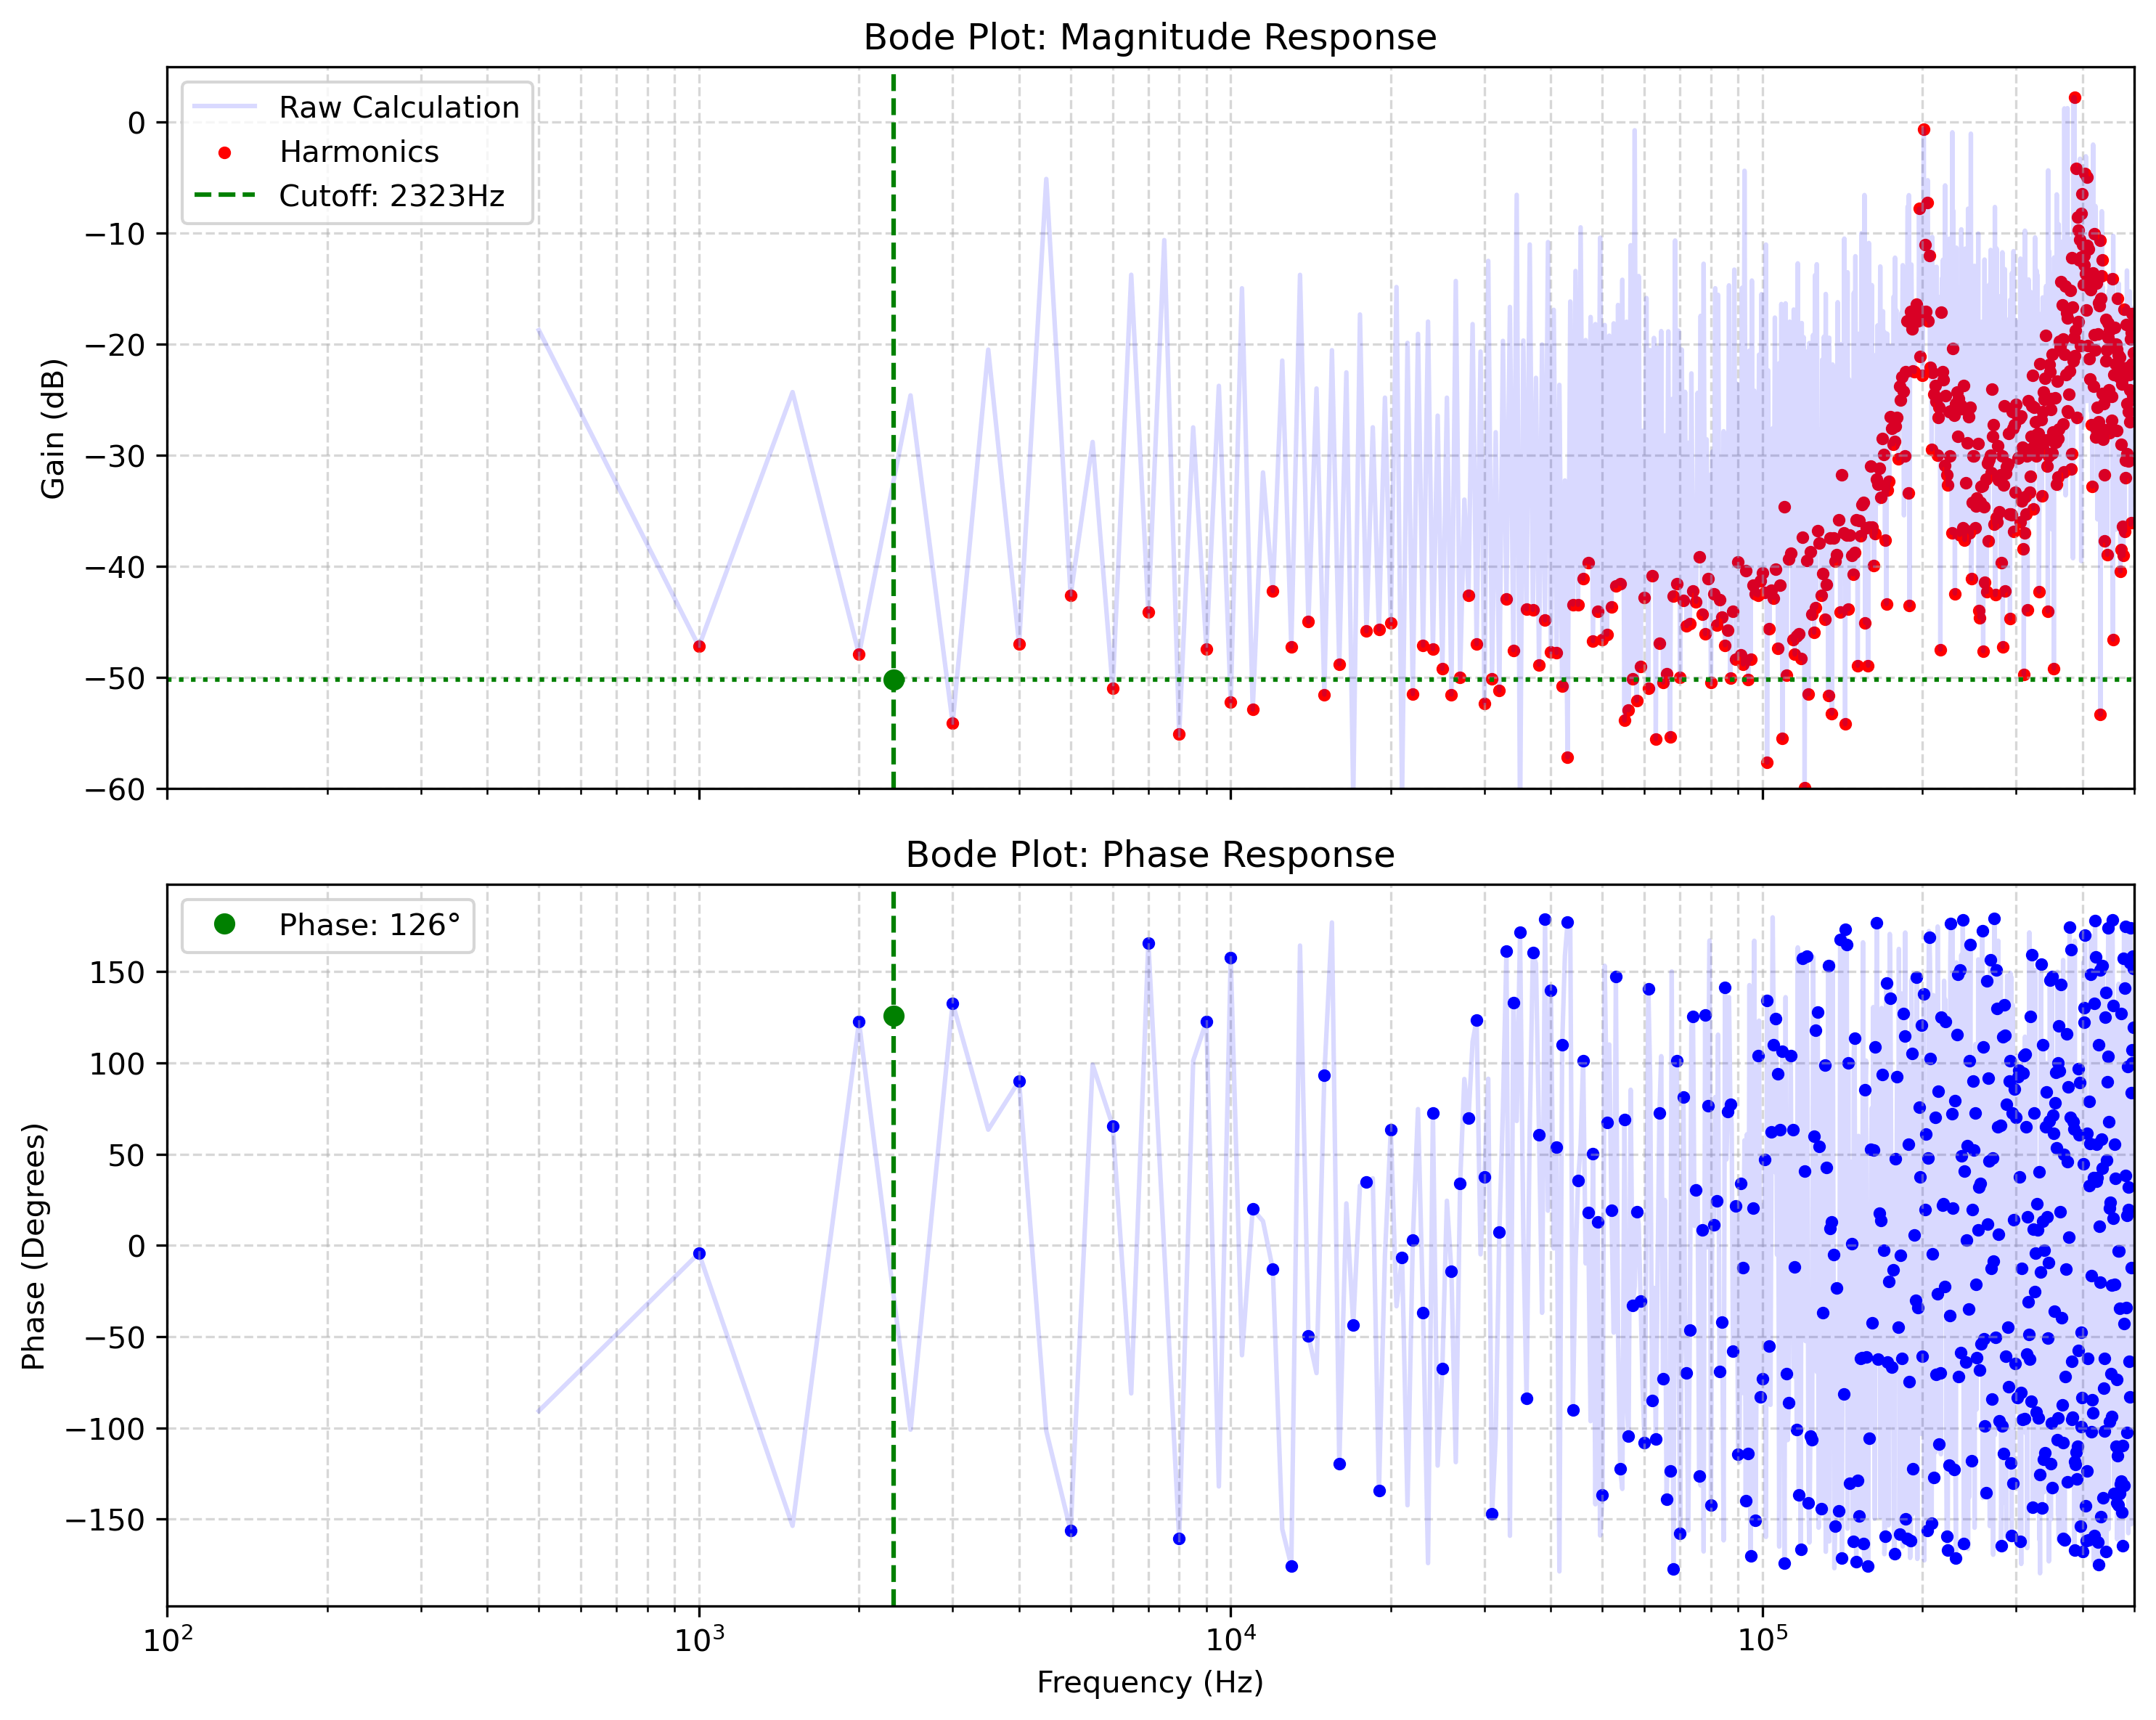

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# 1. Load the data
# Ensure 'input(output).csv' and 'passive_lowpass(output).csv' are in your directory
df_in = pd.read_csv('input(output).csv')
df_out = pd.read_csv('Multiple_Feedback(output2).csv')

# Use the shorter of the two if they differ slightly in length
n = min(len(df_in), len(df_out))
t = df_in['second'].values[:n]
v_in = df_in['Volt'].values[:n]
v_out = df_out['Volt'].values[:n]

# Calculate sampling parameters
dt = t[1] - t[0]
fs = 1.0 / dt

# 2. Perform FFT
fft_in = np.fft.fft(v_in)
fft_out = np.fft.fft(v_out)
freqs = np.fft.fftfreq(n, dt)

# Focus only on positive frequencies
mask = (freqs > 0) & (freqs < fs/2)
f = freqs[mask]
# Calculate Transfer Function H(f)
# Add small epsilon to input to avoid division by zero
H = fft_out[mask] / (fft_in[mask] + 1e-12)

# 3. Calculate Magnitude and Phase
magnitude_db = 20 * np.log10(np.abs(H) + 1e-12)
phase_deg = np.degrees(np.angle(H))

# --- NEW: Parameter Analysis Logic ---

# We extract data only at the harmonics (1kHz, 2kHz...) to perform calculations
# This avoids the "noise" between harmonics
harmonic_indices = np.where((f % 1000 < 50) | (f % 1000 > 950))[0]
f_harm = f[harmonic_indices]
mag_harm = magnitude_db[harmonic_indices]
phase_harm = phase_deg[harmonic_indices]

# A. Passband Gain & Ripple
# Assumes passband starts at DC. Reference is the 1kHz gain.
ref_gain = mag_harm[0] 
# Ripple is the variation before the cutoff point (where gain drops by >3dB)
passband_mask = mag_harm > (ref_gain - 3.0)
if np.any(passband_mask):
    ripple = mag_harm[passband_mask].max() - mag_harm[passband_mask].min()
else:
    ripple = 0.0

# B. Cutoff Frequency (-3dB point)
# Find where gain drops 3dB below the 1kHz reference
cutoff_val = ref_gain - 3.0
cutoff_freq = np.nan

# Interpolate between harmonics to find exact frequency crossing -3dB
for i in range(len(mag_harm) - 1):
    if mag_harm[i] >= cutoff_val and mag_harm[i+1] < cutoff_val:
        # Linear interpolation in Log-Frequency domain
        x1, x2 = np.log10(f_harm[i]), np.log10(f_harm[i+1])
        y1, y2 = mag_harm[i], mag_harm[i+1]
        m = (y2 - y1) / (x2 - x1)
        x_cutoff = (cutoff_val - y1) / m + x1
        cutoff_freq = 10**x_cutoff
        break

# C. Roll-off Rate (Slope)
# Calculate slope between 2x Cutoff and 10x Cutoff
slope = np.nan
if not np.isnan(cutoff_freq):
    slope_mask = (f_harm >= cutoff_freq * 2) & (f_harm <= cutoff_freq * 10)
    if np.sum(slope_mask) > 1:
        # Perform linear regression on log-log data
        slope_f = np.log10(f_harm[slope_mask])
        slope_mag = mag_harm[slope_mask]
        slope_val, intercept, _, _, _ = linregress(slope_f, slope_mag)
        slope = slope_val # Result is in dB/decade

# D. Stopband Attenuation
# Measure attenuation at 10x the Cutoff Frequency
stop_freq = cutoff_freq * 10 if not np.isnan(cutoff_freq) else f_harm[-1]
idx_stop = np.argmin(np.abs(f_harm - stop_freq))
stopband_att = mag_harm[idx_stop]

# E. Phase at Cutoff
phase_at_cutoff = np.interp(cutoff_freq, f_harm, phase_harm) if not np.isnan(cutoff_freq) else np.nan

# Print Results
print("-" * 30)
print(f"Filter Performance Analysis")
print("-" * 30)
print(f"Passband Reference Gain: {ref_gain:.2f} dB")
print(f"Passband Ripple:         {ripple:.2f} dB")
print(f"Cutoff Frequency (-3dB): {cutoff_freq:.2f} Hz")
print(f"Roll-off Rate (Slope):   {slope:.2f} dB/decade")
print(f"Stopband Attenuation:    {stopband_att:.2f} dB (at {stop_freq/1000:.1f} kHz)")
print(f"Phase at Cutoff:         {phase_at_cutoff:.2f} degrees")
print("-" * 30)

# 4. Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, dpi = 300, figsize=(10, 8), sharex=True)

# Plot Magnitude
ax1.semilogx(f, magnitude_db, color='blue', alpha=0.15, label='Raw Calculation')
ax1.scatter(f_harm, mag_harm, color='red', s=10, label='Harmonics')

# Annotate Cutoff
if not np.isnan(cutoff_freq):
    ax1.axvline(x=cutoff_freq, color='green', linestyle='--', label=f'Cutoff: {cutoff_freq:.0f}Hz')
    ax1.axhline(y=cutoff_val, color='green', linestyle=':')
    ax1.plot(cutoff_freq, cutoff_val, 'go')

ax1.set_title('Bode Plot: Magnitude Response')
ax1.set_ylabel('Gain (dB)')
ax1.set_ylim(-60, 5)
ax1.grid(True, which="both", linestyle="--", alpha=0.5)
ax1.legend()

# Plot Phase
ax2.semilogx(f, phase_deg, color='blue', alpha=0.15)
ax2.scatter(f_harm, phase_harm, color='blue', s=10)
if not np.isnan(cutoff_freq):
    ax2.axvline(x=cutoff_freq, color='green', linestyle='--')
    ax2.plot(cutoff_freq, phase_at_cutoff, 'go', label=f'Phase: {phase_at_cutoff:.0f}°')

ax2.set_title('Bode Plot: Phase Response')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Phase (Degrees)')
ax2.set_xlim(100, fs/2)
ax2.grid(True, which="both", linestyle="--", alpha=0.5)
ax2.legend()

plt.tight_layout()
plt.show()